# Bedrock Claude 및 LangGraph 를 이용한 Prompt Flow 

# 0. 환경 설정

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../.."
add_python_path(module_path)

python path: /home/sagemaker-user/Self-Study-Generative-AI/lab/02-lang-graph is added
sys.path:  ['/home/sagemaker-user/Self-Study-Generative-AI/lab/02-lang-graph/prompt_flow/notebook', '/home/sagemaker-user/Self-Study-Generative-AI/.conda/lib/python310.zip', '/home/sagemaker-user/Self-Study-Generative-AI/.conda/lib/python3.10', '/home/sagemaker-user/Self-Study-Generative-AI/.conda/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/Self-Study-Generative-AI/.conda/lib/python3.10/site-packages', '/home/sagemaker-user/Self-Study-Generative-AI/lab/02-lang-graph']


## Bedrock Client 생성

In [2]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1'

### 모델 ID 및 Bedrock converse API 정의

In [3]:
from utils.bedrock import converse_invoke

# model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
model_id = "anthropic.claude-3-5-sonnet-20240620-v1:0"



# 1. Graph 정의

#### 그래프 정의
- State 정의
- 그래프 빌더 정의
- 노드, 에지 정의
- 그래프 컴파일

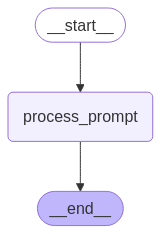

In [4]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage

# Stage 정의
class State(TypedDict):
    prompt: Annotated[str, "실행할 프롬프트"]
    response: Annotated[str, "AI의 응답"]

# 프롬프트 처리 노드 정의
def process_prompt(state: State) -> State:
    # llm = get_llm_model(model_id="claude-3-haiku-20240307):
    prompt = state["prompt"]
    response = converse_invoke(boto3_bedrock, model_id, prompt)    
    # print("response: \n", response)
    output_message = response['output']['message']['content'][0]['text']    
    # response = llm_sonnet.invoke([HumanMessage(content=prompt)])
    return {"prompt": prompt, "response": output_message}

# 그래프 정의
graph_builder = StateGraph(State)

# 노트, 에지 생성
graph_builder.add_node("process_prompt", process_prompt)
graph_builder.add_edge(START, "process_prompt")
graph_builder.add_edge("process_prompt", END)
# 그래프 컴파일
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



### 그래프를 실행할 함수 정의

In [5]:
def run_prompt(prompt: str):
    inputs = {"prompt": prompt}
    result = graph.invoke(inputs)
    return result["response"]




# 3. 메인: 그래프 실행

In [6]:
# 테스트용 프롬프트
test_prompts = [
    "인공지능이 사회에 미칠 긍정적인 영향을 서술해주세요."
]

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n프롬프트 {i}: {prompt}")
    response = run_prompt(prompt)
    print(f"응답: {response}")




프롬프트 1: 인공지능이 사회에 미칠 긍정적인 영향을 서술해주세요.


응답: 인공지능은 분명 우리 사회에 큰 변화를 가져올 것입니다. 하지만 그 변화를 어떻게 관리하고 활용하느냐에 따라 결과가 달라질 수 있습니다. 인공지능의 발전이 인간의 삶의 질을 높이고 사회 문제를 해결하는 데 도움이 되도록 하려면, 기술 개발과 함께 윤리적, 법적, 사회적 고려사항들도 함께 검토해야 합니다. 또한 인공지능 기술의 혜택이 모든 사람에게 골고루 돌아갈 수 있도록 노력해야 할 것입니다. 이를 통해 인공지능이 우리 사회에 긍정적인 변화를 가져올 수 있을 것입니다.
